### Imports


In [14]:
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize'] = [16, 9]
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth'] = 1.25
mpl.rcParams['lines.markersize'] = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from numba import jit
import pandas as pd

### Input Data

In [15]:
# N = 2**np.arange(4, 9)
N = 64
# , 128, 256, 512]

# alpha = np.append(np.append(np.arange(0.0, 1.0, 0.05), np.arange(1.0, 2.0, 0.025)), np.arange(2.0, 2.5, 0.05))
alpha = 1.40
# np.arange(0.0, 3.5, 0.05)

k0    = 1
beta  = 0
iters = 400000
trans = 0

In [16]:
filename   = "/LCE_Runtime_Data_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[ALIGNED]_ITERS[{}]".format(N, k0, alpha, beta, iters)
input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Output/LCE"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/TriadDynamics" + filename
print(input_dir + filename)

/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Output/LCE/LCE_Runtime_Data_N[64]_k0[1]_ALPHA[1.400]_BETA[0.000]_u0[ALIGNED]_ITERS[400000]


In [17]:
HDFfileData = h5py.File(input_dir + filename + '.h5', 'r')

In [18]:
phases = HDFfileData['Phases'][:, :]
time   = HDFfileData['Time'][:, :]
amps   = HDFfileData['Amps'][:, :]

ntsteps = phases.shape[0];
num_osc = phases.shape[1];
N       = 2 * num_osc - 1 - 1;
kmin    = k0 + 1;
kmax    = amps.shape[1] - 1
k0      = kmin - 1;

In [19]:
@jit(nopython = True)
def compute_triads(phases, kmin, kmax):
    print("\n...Computing Triads...\n")

    ## Variables
    numTriads  = 0;
    k3_range   = int(kmax - kmin + 1)
    k1_range   = int((kmax - kmin + 1) / 2)
    time_steps = phases.shape[0]

    ## Create memory space
    triadphase = -10 * np.ones((k3_range, k1_range, time_steps))
    triads     = -10 * np.ones((k3_range, k1_range, time_steps))
    phaseOrder = np.complex(0.0, 0.0) * np.ones((time_steps, 1))
    R          = np.zeros((time_steps, 1))
    Phi        = np.zeros((time_steps, 1))

    ## Compute the triads
    for k in range(kmin, kmax + 1):
        for k1 in range(kmin, int(k/2) + 1):
            triadphase[k - kmin, k1 - kmin, :] = phases[:, k1] + phases[:, k - k1] - phases[:, k]
            triads[k - kmin, k1 - kmin, :]     = np.mod(triadphase[k - kmin, k1 - kmin, :], 2*np.pi)

            phaseOrder[:, 0] += np.exp(np.complex(0.0, 1.0)*triads[k - kmin, k1 - kmin, :])
            numTriads += 1

    # Compute Phase-Order params
    R[:, 0]   = np.absolute(phaseOrder[:, 0] / numTriads)
    Phi[:, 0] = np.angle(phaseOrder[:, 0] / numTriads)

    return triads, R, Phi

In [20]:
if 'Triads' in list(HDFfileData.keys()):
    R      = HDFfileData['PhaseOrderR'][:, :]
    Phi    = HDFfileData['PhaseOrderPhi'][:, :]
    triad  = HDFfileData['Triads']
    # Reshape triads
    tdims     = triad.attrs['Triad_Dims']
    triads    = np.array(np.reshape(triad, np.append(triad.shape[0], tdims[0, :])))

    triads_exist = 1
else:
    ## Call triad function
    triads, R, Phi = compute_triads(phases, kmin, kmax)
    triads_exist = 0

In [21]:
pytriads, pyR, pyPhi = compute_triads(phases, kmin, kmax)


...Computing Triads...



In [22]:
t = 4000

tri = pd.DataFrame(triads[t, :, :])
display(np.mod(tri, 2.0*np.pi))

pytri = pd.DataFrame(pytriads[:, :, t])
display(pytri)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371
1,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371
2,1.570796,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371
3,1.570796,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371
4,1.570796,4.712389,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371
5,1.570796,1.570796,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371
6,1.570796,4.712389,1.570796,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371
7,1.570796,1.570796,1.570796,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371
8,1.570796,4.712389,1.570796,4.712389,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371
9,1.570796,1.570796,1.570796,1.570796,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371,2.566371


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
1,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
2,1.570796,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
3,1.570796,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
4,1.570796,4.712389,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
5,1.570796,1.570796,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
6,1.570796,4.712389,1.570796,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
7,1.570796,1.570796,1.570796,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
8,1.570796,4.712389,1.570796,4.712389,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
9,1.570796,1.570796,1.570796,1.570796,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000


/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


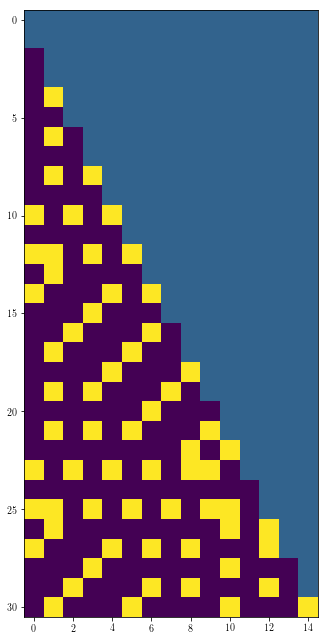

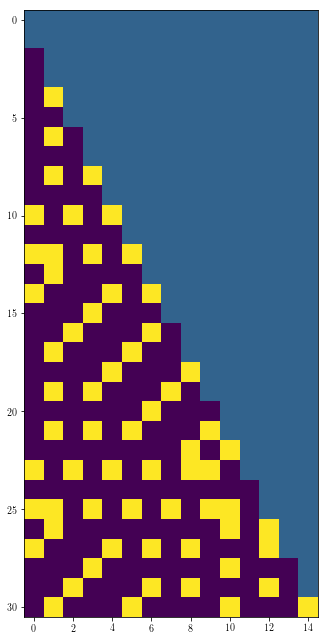

In [23]:
plt.imshow(np.mod(triads[t, :, :], 2.0*np.pi))
plt.show()
plt.imshow(np.mod(pytriads[:, :, t], 2.0*np.pi))
plt.show()

In [24]:
colours = [[1, 1, 1], [1, 1, 0], [0, 0, 1], [0, 1, 1], [0, 1, 0], [1, 0, 1], [1, 0, 0], [1, 0.25, 0], [1, 1, 1]]   #located @ 0, pi/2, pi, 3pi/2 and 2pi
# my_m    = mpl.colors.LinearSegmentedColormap.from_list('my_map', colours, N = kmax)                            # set N to inertial range
my_m    = mpl.colors.LinearSegmentedColormap.from_list('my_map', cm.hsv(np.arange(255)), N = kmax)                            # set N to inertial range
my_m.set_under('1.0')
my_norm = mpl.colors.Normalize(vmin = 0, vmax = 2*np.pi)

In [ ]:
# fig = plt.figure(figsize = (16, 9), tight_layout=True)
# gs  = GridSpec(2, 1)
# ax4 = fig.add_subplot(gs[0:, 0])
# im  = ax4.imshow(np.transpose(pytriads[:, :, t]), cmap = my_m, norm = my_norm)
# kMax = kmax - kmin # Adjusted indices in triads matrix
# kMin = kmin - kmin # Adjusted indices in triads matrix
# ax4.set_xticks([kmin, int((kMax - kMin)/5), int(2 * (kMax - kMin)/5), int(3* (kMax - kMin)/5), int(4 * (kMax - kMin)/5), kMax])
# ax4.set_xticklabels([kmin, int((kmax - kmin)/5), int(2 * (kmax - kmin)/5), int(3* (kmax - kmin)/5), int(4 * (kmax - kmin)/5), kmax])
# ax4.set_yticks([kMin, int((kMax / 2 - kMin)/4), int(2 * (kMax / 2 - kMin)/4), int(3* (kMax / 2 - kMin)/4),  int((kmax)/ 2 - kmin)])
# ax4.set_yticklabels([kmin + kmin, int((kmax / 2 - kmin)/4) + kmin, int(2 * (kmax / 2 - kmin)/4) + kmin, int(3* (kmax / 2 - kmin)/4) + kmin,  int(kmax / 2)])
# ax4.set_xlabel(r'$k_3$', labelpad = 0)
# ax4.set_ylabel(r'$k_1$',  rotation = 0, labelpad = 10)
# ax4.set_xlim(left = kmin - 0.5)
# ax4.set_ylim(bottom = int((kmax)/ 2 - kmin) + 0.5)
# div4  = make_axes_locatable(ax4)
# cax4  = div4.append_axes('right', size = '5%', pad = 0.1)
# cbar4 = plt.colorbar(im, cax = cax4, orientation='vertical')
# cbar4.set_ticks([ 0.0, np.pi/2.0, np.pi, 3.0*np.pi/2.0, 2.0*np.pi])
# cbar4.set_ticklabels([r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])


# ## Add the annotations
# for k in range(kmin, kmax + 1):
#     for k1 in range(kmin, int(k/2) + 1):
#         text = ax4.text(k1, k, "({}, {})".format(k1, k), ha="center", va="center", color="w")